In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

from datetime import datetime
import os

In [2]:
path_to_experiment_data = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'all_experiments.csv')

df = pd.read_csv(path_to_experiment_data)

# convert the timestamp to a datetime object
df['short_date'] = df['Created'].str.slice(0, len('2023-01-20'))
df['short_date'] = pd.to_datetime(df['short_date'])

df.head()

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,batch_size,chain_length,...,val_jsd_alpha=100,val_jsd_alpha=1000,val_jsd_alpha=10000,val_mean Bayesian score_alpha=1,val_mean Bayesian score_alpha=10,val_mean Bayesian score_alpha=100,val_mean Bayesian score_alpha=1000,val_mean Bayesian score_alpha=10000,val_num_unique_demos,short_date
0,perfect-teacher_random-demo_k=20_5,finished,-,dharakyu,NaN,2023-01-27T09:13:44.000Z,281,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-27
1,perfect-teacher_random-demo_k=20_4,finished,-,dharakyu,NaN,2023-01-27T09:08:45.000Z,292,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-27
2,perfect-teacher_random-demo_k=20_3,finished,-,dharakyu,NaN,2023-01-27T09:03:48.000Z,290,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-27
3,perfect-teacher_random-demo_k=20_2,finished,-,dharakyu,NaN,2023-01-27T08:58:44.000Z,298,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-27
4,perfect-teacher_random-demo_k=20_1,finished,-,dharakyu,NaN,2023-01-27T08:53:56.000Z,282,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-27


In [15]:
def get_train_and_val_data(rewards, stat):
    """
    Helper function to compute the specified statistic (mean or std)
    over the train and val data from the rewards df.
    
    Arguments:
        rewards (Dict[int, Dict[str, List[int]]]): maps x value (e.g. 1) to a dict mapping 
            split name (e.g. 'train' or 'val') to a list of values
        stat (str): 'mean' or 'std'
        
    Return:
        np.array of the statistic for the train and validation sets
        
    """
    rewards_train_values = []
    rewards_val_values = []
    for size in rewards:
        if stat == 'mean':
            train_value = np.mean(rewards[size]['train'])
            val_value = np.mean(rewards[size]['val'])
            
        if stat == 'std':
            train_value = np.std(rewards[size]['train'], ddof=1)/np.sqrt(np.size(rewards[size]['train']))
            val_value = np.std(rewards[size]['val'], ddof=1)/np.sqrt(np.size(rewards[size]['train']))
        
        rewards_train_values.append(train_value)
        rewards_val_values.append(val_value)
        
    rewards_train_values = np.array(rewards_train_values)
    rewards_val_values = np.array(rewards_val_values)

    return rewards_train_values, rewards_val_values

## Effect of communication channel size

Here we visualize how the size of communication channel affects student performance on the task.

In [16]:
def get_channel_sweep_reward_data(modality):
    """
    Grabs the relevant data for showing effect of communication channel size
    
    Arguments:
        modality (str): specifies the string name used to select the data we are
        looking for ('lang' or 'demo')
        
    Return:
        rewards (Dict[int, Dict[str, List[int]]]): maps x value (e.g. 1) to a dict mapping 
            split name (e.g. 'train' or 'val') to a list of values
    """
    
    # hard code the communication channel sizes
    demo_sizes = [1, 2, 5, 10, 20]
    lang_sizes = [item+2 for item in demo_sizes]
    
    if modality == 'lang-len': sizes = lang_sizes
    else: sizes = demo_sizes
        
    rewards = {}
    for i in sizes:
        # filter out to the specified modality and channel size
        data = df[df['Name'].str.contains(modality) \
                 & df['Name'].str.contains("={}_".format(i)) \
                 & (df['short_date'] > datetime.strptime('2023-01-15', '%Y-%m-%d'))]
        
        train_reward = data['train_reward_1'].tolist()
        val_reward = data['val_reward_1'].tolist()
        rewards[i] = {}
        rewards[i]['train'] = train_reward
        rewards[i]['val'] = val_reward
        
    return rewards

In [17]:
# get the data

lang_rewards = get_channel_sweep_reward_data('lang-len')
rand_rewards = get_channel_sweep_reward_data('random-demo_')
ped_rewards = get_channel_sweep_reward_data('pedagogical-demo_')

lang_train_means, lang_val_means = get_train_and_val_data(lang_rewards, 'mean')
rand_train_means, rand_val_means = get_train_and_val_data(rand_rewards, 'mean')
ped_train_means, ped_val_means = get_train_and_val_data(ped_rewards, 'mean')

lang_train_stds, lang_val_stds = get_train_and_val_data(lang_rewards, 'std')
rand_train_stds, rand_val_stds = get_train_and_val_data(rand_rewards, 'std')
ped_train_stds, ped_val_stds = get_train_and_val_data(ped_rewards, 'std')

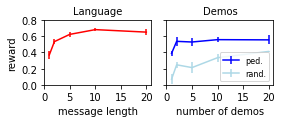

In [22]:
# plot figure

demo_x_axis = [1, 2, 5, 10, 20]
lang_x_axis = [3, 4, 7, 12, 22]

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.8), sharey=True)

# language
ax0.errorbar(demo_x_axis, lang_val_means, yerr=lang_val_stds, linestyle='-',color='red', label='lang.')
ax0.set_ylim([0, 0.8])
ax0.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax0.set_xticks([0, 5, 10, 15, 20])
ax0.set_xlabel('message length')
#ax0.legend(loc='lower right')
ax0.set_ylabel('reward')
ax0.set_title('Language', fontdict={'fontsize': 10})


# demos
ax1.errorbar(demo_x_axis, ped_val_means, yerr=ped_val_stds, linestyle='-', color='blue', label='ped.')
ax1.errorbar(demo_x_axis, rand_val_means, yerr=rand_val_stds, linestyle='-', color='lightblue', label='rand.')

ax1.set_ylim([0, 0.8])
ax1.set_xticks([0, 5, 10, 15, 20])

#box = ax1.get_position()
#ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax1.set_xlabel('number of demos')
#ax1.set_ylabel('reward')
ax1.legend(loc='lower right', prop={'size': 8}, bbox_to_anchor=(1, 0))
ax1.set_title('Demos', fontdict={'fontsize': 10})

fig.tight_layout(pad=1)
#plt.xticks([3, 4, 5, 6])
plt.show()

## Effect of reward matrix size (game difficulty)

Here we visualize how changing the size of the reward matrix affects reward.

In [23]:
def get_reward_data(run_name):
    """
    Arguments:
        run_name (str): specify run name pattern to pull out
        
    Return:
        rewards (Dict[int, Dict[str, List[int]]]): map reward matrix size to train and val splits data
    """

    rewards = {}
    # specify different values of n
    for i in [3, 4, 5, 6]:
        data = df[df['Name'].str.contains(run_name) \
                 & df['Name'].str.contains("{}x{}".format(i, i))]
        train_reward = data['train_reward_1'].tolist()
        val_reward = data['val_reward_1'].tolist()
        rewards[i] = {}
        rewards[i]['train'] = train_reward
        rewards[i]['val'] = val_reward
    
    return rewards

In [24]:
# get the data
ped_sampling_rewards = get_reward_data('perfect-teacher_pedagogical-sampling')
lang_rewards = get_reward_data('perfect-teacher_lang')

ped_train_means, ped_val_means = get_train_and_val_data(ped_sampling_rewards, 'mean')
lang_train_means, lang_val_means = get_train_and_val_data(lang_rewards, 'mean')

ped_train_stds, ped_val_stds = get_train_and_val_data(ped_sampling_rewards, 'std')
lang_train_stds, lang_val_stds = get_train_and_val_data(lang_rewards, 'std')

In [25]:
# see what the data looks like
ped_train_means+ped_train_stds

array([0.71144042, 0.56316828, 0.41271518, 0.36687174])

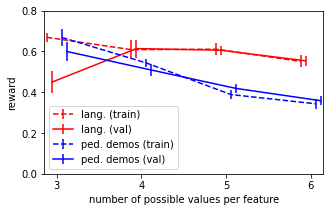

In [26]:
# plot

x_vals = [3, 4, 5, 6]
fig, ax = plt.subplots(figsize=(5, 3))

# adjustments so that the data points are slightly offset as to not overlap
lang_train_trans = ax.transData + ScaledTranslation(-10/72, 0, fig.dpi_scale_trans)
lang_val_trans = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
demo_train_trans = ax.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)
demo_val_trans = ax.transData + ScaledTranslation(+10/72, 0, fig.dpi_scale_trans)

ax.errorbar(x_vals, lang_train_means, yerr=lang_train_stds, linestyle='--', color='red', label='lang. (train)',
           transform=lang_train_trans)

ax.errorbar(x_vals, lang_val_means, yerr=lang_val_stds, linestyle='-',color='red', label='lang. (val)',
           transform=lang_val_trans)

ax.errorbar(x_vals, ped_train_means, yerr=ped_train_stds, linestyle='--', color='blue', label='ped. demos (train)',
           transform=demo_train_trans)

ax.errorbar(x_vals, ped_val_means, yerr=ped_val_stds, linestyle='-', color='blue', label='ped. demos (val)',
           transform=demo_val_trans)

plt.legend(loc='lower left')
plt.xlabel('number of possible values per feature')
plt.ylabel('reward')
plt.xticks([3, 4, 5, 6])
plt.ylim([0.0, 0.8])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8])
plt.show()

## Effect of train set size (teacher competence)

Here we visualize the effect of reducing the size of the training set on the student's reward.

In [14]:
# here's what the data looks like

df[df['Name'].str.contains('train-percent')].head(5)

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,batch_size,chain_length,...,val_jsd_alpha=10,val_jsd_alpha=100,val_jsd_alpha=1000,val_jsd_alpha=10000,val_mean Bayesian score_alpha=1,val_mean Bayesian score_alpha=10,val_mean Bayesian score_alpha=100,val_mean Bayesian score_alpha=1000,val_mean Bayesian score_alpha=10000,val_num_unique_demos
0,perfect-teacher_lang_train-percent=0.05_5,finished,-,dharakyu,NaN,2023-01-20T19:22:37.000Z,752,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,perfect-teacher_lang_train-percent=0.05_4,finished,-,dharakyu,NaN,2023-01-20T19:10:46.000Z,705,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,perfect-teacher_lang_train-percent=0.05_3,finished,-,dharakyu,NaN,2023-01-20T18:59:27.000Z,672,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,perfect-teacher_lang_train-percent=0.05_2,finished,-,dharakyu,NaN,2023-01-20T18:47:02.000Z,739,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,perfect-teacher_lang_train-percent=0.05_1,finished,-,dharakyu,NaN,2023-01-20T18:34:59.000Z,717,NaN,32,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def get_reward_data_for_train_size(run_name):
    """
    Arguments:
        run_name (str): specify run name pattern to pull out
        
    Return:
        rewards (Dict[int, Dict[str, List[int]]]): map reward matrix size to train and val splits data
    """
    rewards = {}
    
    # specify different values for the train set size to pull out
    train_set_sizes = list(np.arange(0.7, 0.0, -0.1)) + [0.05]
    train_set_sizes_str = [str(round(val, 2)) for val in train_set_sizes]
    
    for size in train_set_sizes_str:
        data = df[df['Name'].str.contains('train-percent') \
                    & df['Name'].str.contains(run_name) \
                    & df['Name'].str.contains("={}".format(size)) \
                    & (df['short_date'] > datetime.strptime('2023-01-15', '%Y-%m-%d'))
                    & (df['short_date'] < datetime.strptime('2023-01-21', '%Y-%m-%d'))]
        
        train_reward = data['train_reward_1'].tolist()
        val_reward = data['val_reward_1'].tolist()

        rewards[size] = {}
        rewards[size]['train'] = train_reward
        rewards[size]['val'] = val_reward
        
    return rewards

In [28]:
# get the data

lang_train_size_rewards = get_reward_data_for_train_size('lang')
ped_train_size_rewards = get_reward_data_for_train_size('pedagogical')

ped_train_means, ped_val_means = get_train_and_val_data(ped_train_size_rewards, 'mean')
lang_train_means, lang_val_means = get_train_and_val_data(lang_train_size_rewards, 'mean')

ped_train_stds, ped_val_stds = get_train_and_val_data(ped_train_size_rewards, 'std')
lang_train_stds, lang_val_stds = get_train_and_val_data(lang_train_size_rewards, 'std')

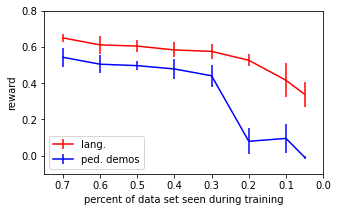

In [29]:
# plot

fig, ax = plt.subplots(figsize=(5, 3))
x_vals = list(np.arange(0.7, 0.0, -0.1)) + [0.05]

plt.errorbar(x_vals, lang_val_means, yerr=lang_val_stds, linestyle='-',color='red', label='lang.')
plt.errorbar(x_vals, ped_val_means, yerr=ped_val_stds, linestyle='-', color='blue', label='ped. demos')

plt.legend(loc='lower left')
plt.xlabel('percent of data set seen during training')
plt.ylabel('reward')
plt.xlim(0.75, 0)
plt.ylim(-0.1, 0.8)
plt.show()

## Combining game difficulty and data quantity figures

Here we simply combine the previous 2 figures into one figure for space-saving purposes.

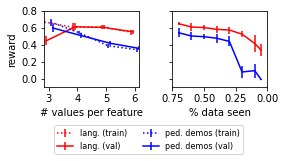

In [30]:
"""
Game difficulty subplot
"""
# get the data
ped_sampling_rewards = get_reward_data('perfect-teacher_pedagogical-sampling')
lang_rewards = get_reward_data('perfect-teacher_lang')

ped_train_means, ped_val_means = get_train_and_val_data(ped_sampling_rewards, 'mean')
lang_train_means, lang_val_means = get_train_and_val_data(lang_rewards, 'mean')

ped_train_stds, ped_val_stds = get_train_and_val_data(ped_sampling_rewards, 'std')
lang_train_stds, lang_val_stds = get_train_and_val_data(lang_rewards, 'std')

# plot
x_vals = [3, 4, 5, 6]
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(4, 1.4), sharey=True)

lang_train_trans = ax0.transData + ScaledTranslation(-10/172, 0, fig.dpi_scale_trans)
lang_val_trans = ax0.transData + ScaledTranslation(-5/172, 0, fig.dpi_scale_trans)
demo_train_trans = ax0.transData + ScaledTranslation(+5/172, 0, fig.dpi_scale_trans)
demo_val_trans = ax0.transData + ScaledTranslation(+10/172, 0, fig.dpi_scale_trans)

ax0.errorbar(x_vals, lang_train_means, yerr=lang_train_stds, linestyle=':', color='red', label='lang. (train)',
           transform=lang_train_trans)

ax0.errorbar(x_vals, lang_val_means, yerr=lang_val_stds, linestyle='-',color='red', label='lang. (val)',
           transform=lang_val_trans)

ax0.errorbar(x_vals, ped_train_means, yerr=ped_train_stds, linestyle=':', color='blue', label='ped. demos (train)',
           transform=demo_train_trans)

ax0.errorbar(x_vals, ped_val_means, yerr=ped_val_stds, linestyle='-', color='blue', label='ped. demos (val)',
           transform=demo_val_trans)

#ax0.legend(loc='lower left')
ax0.set_xlabel('# values per feature')
ax0.set_ylabel('reward')
ax0.set_xticks([3, 4, 5, 6])
ax0.set_ylim([0.0, 0.8])
ax0.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])

ax0.legend(bbox_to_anchor=(1.1, -0.45), loc='upper center', ncol=2, prop={'size': 8})

"""
Data quantity subplot
"""
# get data
lang_train_size_rewards = get_reward_data_for_train_size('lang')
ped_train_size_rewards = get_reward_data_for_train_size('pedagogical')

ped_train_means, ped_val_means = get_train_and_val_data(ped_train_size_rewards, 'mean')
lang_train_means, lang_val_means = get_train_and_val_data(lang_train_size_rewards, 'mean')

ped_train_stds, ped_val_stds = get_train_and_val_data(ped_train_size_rewards, 'std')
lang_train_stds, lang_val_stds = get_train_and_val_data(lang_train_size_rewards, 'std')

# plot
x_vals_2 = list(np.arange(0.7, 0.0, -0.1)) + [0.05]

ax1.errorbar(x_vals_2, lang_val_means, yerr=lang_val_stds, linestyle='-',color='red', label='lang.')
ax1.errorbar(x_vals_2, ped_val_means, yerr=ped_val_stds, linestyle='-', color='blue', label='ped. demos')

#ax1.legend(loc='lower left')
ax1.set_xlabel('% data seen')
#ax1.set_ylabel('reward')
#ax1.set_xticks(np.arange(0.7, 0.0, -0.1))
ax1.set_xlim(0.75, 0)
ax1.set_ylim(-0.1, 0.8)

plt.subplots_adjust(wspace=0.35)
plt.show()